# CPR

Popova <a href=http://projecteuclid.org/download/pdf_1/euclid.ba/1340370553>states</a> that the scheduled monthly payment is defined as follows: 
$$ MonthlyPayment = \frac{V \cdot \tfrac{r}{12} \cdot (1 + \tfrac{r}{12})^t}{(1 + \tfrac{r}{12})^t - 1} $$
$$ InterestPayment = V \cdot \frac{r}{12} $$
$$ ScheduledPrincipalPayment = MP - IP$$
Where $V$ is the face value of the loan, $r$ is the interest rate, and $t$ is the number of months since inception. She only looked at 8% loans.

Can I match up against Bloomberg CPR?

In [1]:
import os
os.chdir("/home/charles/src/LondonMirror/Prepayments/")
import prepayments as pp
import pandas as pd
import numpy as np
import datetime

In [2]:
import ggplot as gg

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
gnm_pool = pp.gnm_data.GNM_Pool()

In [5]:
samples = gnm_pool.get_samples(1000)

In [6]:
samples[0]

(12406987, '485527', datetime.datetime(2016, 5, 1, 0, 0))

In [7]:
samples[0] = (1698292, '687716', datetime.datetime(2012, 8, 1, 0, 0))

In [8]:
bbg = pp.Bloomberg()

In [9]:
cusip = gnm_pool.pools_table[samples[0][0]]["cusip"]
cusip

'36296DAR9'

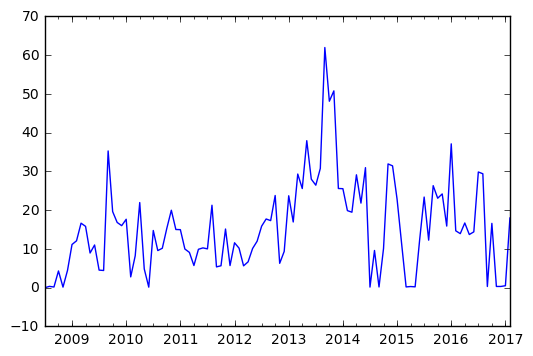

In [10]:
cpr_bbg = bbg.get_cpr(cusip)
cpr_bbg.plot()

In [11]:
p_data = gnm_pool.df_for_pool_number(samples[0][1])
p_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 2012-02-01 to 2016-12-01
Data columns (total 93 columns):
aols                                          59 non-null int64
as_of_date                                    59 non-null datetime64[ns]
cusip                                         59 non-null object
few_units_number_of_loans                     59 non-null int32
few_units_pct_of_upb                          59 non-null int32
few_units_upb                                 59 non-null int64
first_quartile_aols_q1                        59 non-null int64
first_quartile_cltv_q1                        59 non-null int16
first_quartile_ltv_q1                         59 non-null int16
first_quartile_wac_q1                         59 non-null int32
first_quartile_wagm_q1                        59 non-null int32
first_quartile_wala_q1                        59 non-null int16
first_quartile_waolt_q1                       59 non-null int16
first_quartile_warm_q1                     

In [13]:
p_data.ix[:,['security_interest_rate','wac']]

,security_interest_rate,wac
2012-02-01,5500,6000
2012-03-01,5500,6000
2012-04-01,5500,6000
2012-05-01,5500,6000
2012-06-01,5500,6000
2012-07-01,5500,6000
2012-08-01,5500,6000
2012-09-01,5500,6000
2012-10-01,5500,6000
2012-11-01,5500,6000


In [22]:
def scheduled_payment(face_value, interest_rate, loan_age):
    rate = interest_rate / 120000.
    compound_rate = (1 + rate) ** loan_age
    monthly_payment = (face_value * rate * compound_rate) / (compound_rate - 1)
    interest_payment = face_value * rate
    return monthly_payment - interest_payment

In [23]:
sp = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['security_interest_rate'], v['wala']) 
               for dt,v in p_data.iterrows()})

In [99]:
def cpr(p_data):
    sp = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'],
                                         v['security_interest_rate'],
                                         v['wala']) 
               for dt,v in p_data.iterrows()})
    smm = (0-p_data['pool_upb'].diff()).sub(sp).div(p_data['pool_upb'])
    cpr = 1 - (1-smm).pow(12)
    cpr.index = pd.DatetimeIndex(cpr.index)
    return cpr.shift(1)

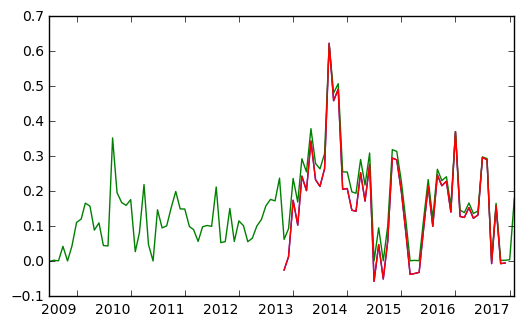

In [84]:
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
(1 - (1 - smm.shift(1)).pow(12)).plot()
cpr_bbg.div(100).plot()
cpr(p_data.ix[datetime.date(2012,9,1):]).plot()

close, but no banana.

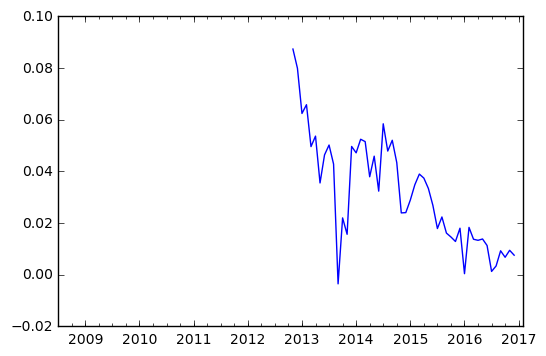

In [85]:
cpr_bbg.div(100).sub(cpr(p_data.ix[datetime.date(2012,9,1):])).plot()

Maybe it should be 'wac'?

In [94]:
sp2 = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['wac'], v['wala']) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp2).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr2 = (1 - (1 - smm.shift(1)).pow(12))
cpr2.index = pd.DatetimeIndex(cpr2.index)

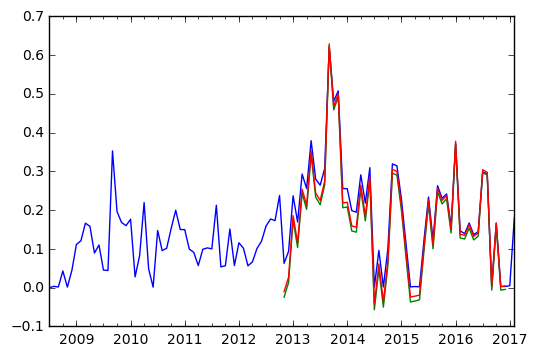

In [100]:
cpr_bbg.div(100).plot()
cpr(p_data.ix[datetime.date(2012,9,1):]).plot()
cpr2.plot()

Nope. Perhaps something to do with `wala`? The difference drops over time. I think I'm going to prefer bloomberg CPR, fill in with my CPR if necessary.

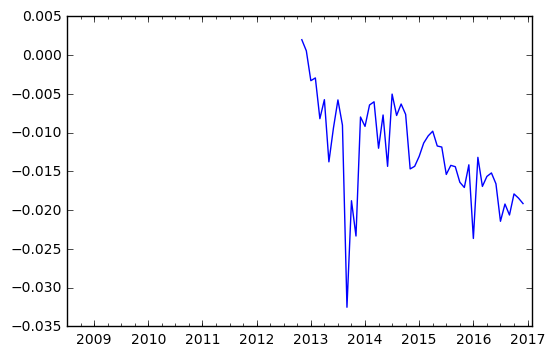

In [122]:
sp2 = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['wac'], v['wala']+30) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp2).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr2 = (1 - (1 - smm.shift(1)).pow(12))
cpr2.index = pd.DatetimeIndex(cpr2.index)
cpr_bbg.div(100).sub(cpr2).plot()

Maybe `wac`, `wala+30`, plus proper compounding of interest rate?

In [140]:
def scheduled_payment2(face_value, interest_rate, loan_age):
    rate = interest_rate / 100000.
    rate = (1+rate) ** (1/12.) - 1
    compound_rate = (1 + rate) ** loan_age
    monthly_payment = (face_value * rate * compound_rate) / (compound_rate - 1)
    interest_payment = face_value * rate
    return monthly_payment - interest_payment

In [146]:
((1+p_data.ix[0,'wac'] / 100000.) ** (1/12.)) ** 100

1.6251079337846082

In [147]:
((p_data.ix[0,'wac']/ 120000.)+1) ** 12

1.7958563260221301

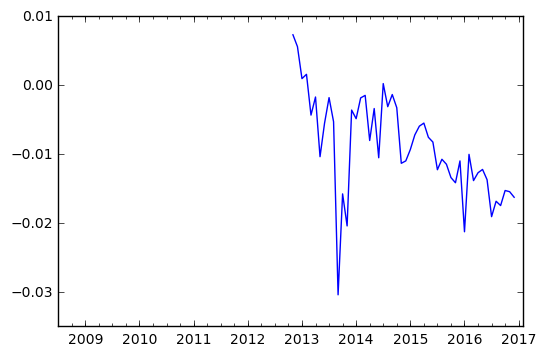

In [152]:
sp2 = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['security_interest_rate'], v['wala']+30) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp2).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr2 = (1 - (1 - smm.shift(1)).pow(12))
cpr2.index = pd.DatetimeIndex(cpr2.index)
cpr_bbg.div(100).sub(cpr2).plot()

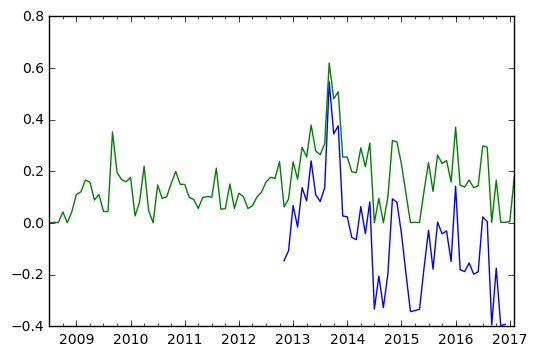

In [149]:
cpr2.plot()
cpr_bbg.div(100).plot()

Nope, that's further off. What about PSA adjustment?

In [166]:
def scheduled_payment3(face_value, interest_rate, loan_age):
    rate = interest_rate / 100000.
    rate = (1+rate) ** (1/12.) - 1
    compound_rate = (1 + rate) ** (loan_age-30)
    psa_adj = np.prod([1 + (x*rate / 30) for x in xrange(30)])
    compound_rate = compound_rate + psa_adj
    monthly_payment = (face_value * rate * compound_rate) / (compound_rate - 1)
    interest_payment = face_value * rate
    return monthly_payment - interest_payment

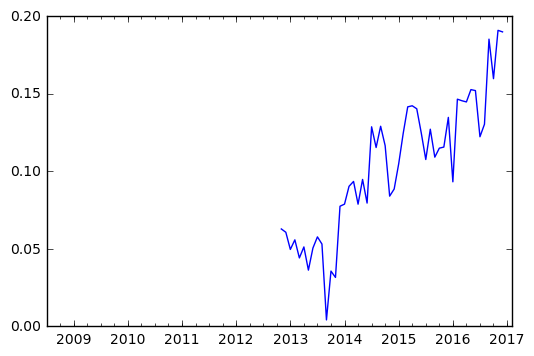

In [168]:
sp3 = pd.Series({dt:scheduled_payment3(v['original_aggregate_amount'], v['security_interest_rate'], v['wala']) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp3).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr2 = (1 - (1 - smm.shift(1)).pow(12))
cpr2.index = pd.DatetimeIndex(cpr2.index)
cpr_bbg.div(100).sub(cpr2).plot()

Maybe I'd better check a different cusip.

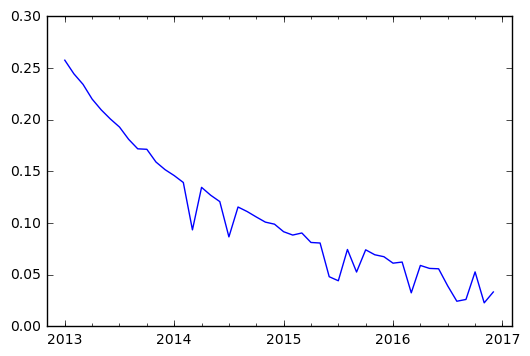

In [188]:
p_data = gnm_pool.df_for_pool_number(samples[911][1])
cpr_bbg = bbg.get_cpr(gnm_pool.pools_table[samples[911][0]]['cusip']).div(100)

sp = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['security_interest_rate'], v['wala']+30) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr = (1 - (1 - smm.shift(1)).pow(12))
cpr.index = pd.DatetimeIndex(cpr.index)
cpr_bbg.sub(cpr).plot()

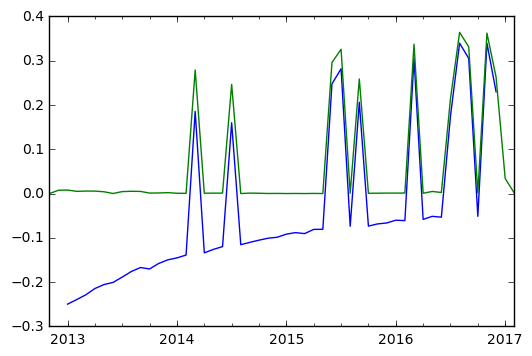

In [189]:
cpr.plot()
cpr_bbg.plot()

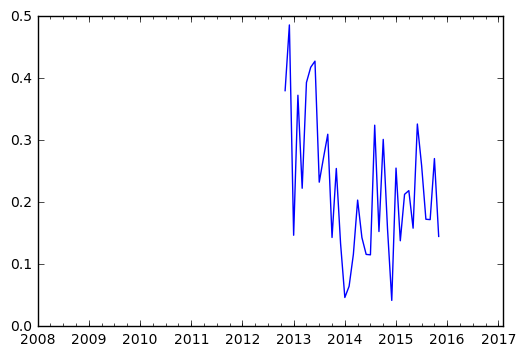

In [190]:
p_data = gnm_pool.df_for_pool_number(samples[50][1])
cpr_bbg = bbg.get_cpr(gnm_pool.pools_table[samples[50][0]]['cusip']).div(100)

sp = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['security_interest_rate'], v['wala']+30) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr = (1 - (1 - smm.shift(1)).pow(12))
cpr.index = pd.DatetimeIndex(cpr.index)
cpr_bbg.sub(cpr).plot()

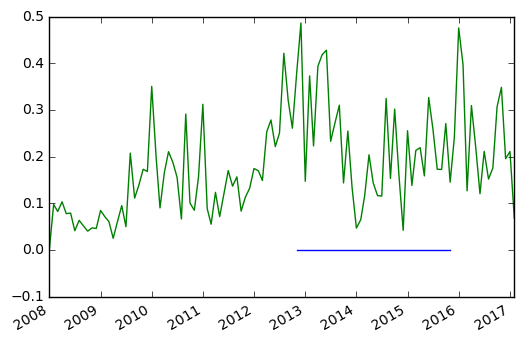

In [191]:
cpr.plot()
cpr_bbg.plot()

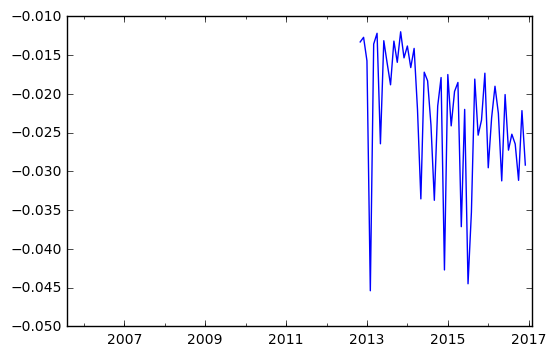

In [192]:
p_data = gnm_pool.df_for_pool_number(samples[666][1])
cpr_bbg = bbg.get_cpr(gnm_pool.pools_table[samples[666][0]]['cusip']).div(100)

sp = pd.Series({dt:scheduled_payment(v['original_aggregate_amount'], v['security_interest_rate'], v['wala']+30) 
               for dt,v in p_data.iterrows()})
smm = (0-p_data['pool_upb'].ix[datetime.date(2012,9,1):].diff()).sub(sp).div(p_data['pool_upb'].ix[datetime.date(2012,9,1):])
cpr = (1 - (1 - smm.shift(1)).pow(12))
cpr.index = pd.DatetimeIndex(cpr.index)
cpr_bbg.sub(cpr).plot()

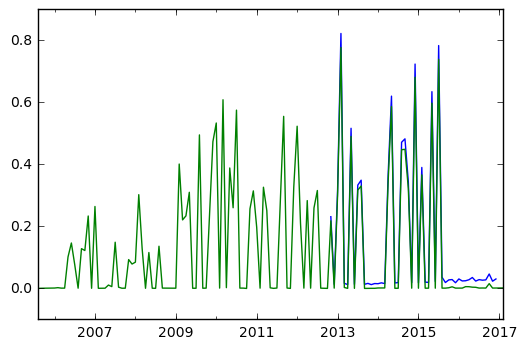

In [193]:
cpr.plot()
cpr_bbg.plot()

I've checked a few and mine are all over the place. 

Some are missing some time-related component, but some are just way off. 

I think I'd better just stick with BBG.